# Magnetic susceptibility tensor

This notebook illustrates how to estimate the magnetic susceptibility tensor of a rock sample. For details, see Hext (1963) and Tauxe (2003, p. 173).

* Hext, George R. “The Estimation of Second-Order Tensors, with Related Tests and Designs.” Biometrika 50, no. 3–4 (1963): 353–73. https://doi.org/10.1093/biomet/50.3-4.353
* Tauxe, Lisa. Paleomagnetic Principles and Practice. Kluwer Academic Publishers, 2003

Take a look at the file `magnetic_susceptibility_tensor.pdf`.

In [1]:
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget
# aka import ipympl

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def unit_vector(inc, dec):
    '''
    Define a unit vector v from its inclination
    and declination as follows:

    v1 = cos(inc) cos(dec)
    v2 = cos(inc) sin(dec)
    v3 = sin(inc)

    where v1, v2 and v3 are the components of v along the x, y and z 
    directions of a local Cartesian system.

    parameters
    ----------
    inc, dec : floats
        Inclination and declination (in degrees) of the unit vector, respectively.

    returns
    -------
    v : numpy array 1d
        Unit vector with components v1, v2 and v3.
    '''
    
    # verify the input parameters
    if isinstance(inc, (float, int)) is not True:
        raise ValueError("inc must float or int")
    if isinstance(dec, (float, int)) is not True:
        raise ValueError("dec must float or int")

    # convert inc and dec from degrees to radian
    I = np.deg2rad(inc)
    D = np.deg2rad(dec)

    # define the unit vector components
    v = np.array([np.cos(I)*np.cos(D), np.cos(I)*np.sin(D), np.sin(I)])

    return v

In [4]:
def draw_region(
    ax, xmin, xmax, ymin, ymax, zmin, zmax, label_size=14, ticks_size=12
):
    '''
    Draw the 3D region where the objects will be plotted.

    Parameters
    ----------
    ax : axes of a matplotlib figure.
        xmin, xmax, ymin, ymax, zmin, zmax: floats
        Lower and upper limites along the x-, y- and z- axes.
    '''
    for boundary in [xmin, xmax, ymin, ymax, zmin, zmax]:
        if isinstance(boundary, (int, float)) is not True:
            raise ValueError("All boundaries must be int or float.")
    for (lower, upper) in [(xmin, xmax), (ymin, ymax), (zmin, zmax)]:
        if lower >= upper:
            raise ValueError("Lower boundaries must be smaller than upper boundaries.")

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)
    ax.grid()
    ax.xaxis.set_tick_params(labelsize=ticks_size)
    ax.yaxis.set_tick_params(labelsize=ticks_size)
    ax.zaxis.set_tick_params(labelsize=ticks_size)
    ax.set_xlabel("x (m)", fontsize=label_size)
    ax.set_ylabel("y (m)", fontsize=label_size)
    ax.set_zlabel("z (m)", fontsize=label_size)

In [5]:
def draw_vector(vector, origin=np.zeros(3), color='k', linewidth=1):
    '''
    Draw a vector with given origin and Cartesian components.

    Parameters
    ----------
    vector : numpy array 1d
        Cartesian components of the vector to be plotted.
    origin : numpy array 1d
        Cartesian components of the point where the vector is attached.
        Default is a vector of zeros.
    color : Matplotlib color 
        The color attibuted to the plotted vector. Colors are specified according to:
        https://matplotlib.org/stable/users/explain/colors/colors.html#colors-def .
        Default is black ('k').
    linewidth : positive scalar
        Positive scalar defining the linewidth of the plotted vector.
        Default is 1.
    '''
    for parameter in [vector, origin]:
        if isinstance(parameter, np.ndarray) is not True:
            raise ValueError("all input parameters must be numpy arrays.")
        if parameter.ndim != 1:
            raise ValueError("all input parameters must have ndim = 1.")
        if parameter.size != 3:
            raise ValueError("all input parameters must have size = 3.")
    if isinstance(linewidth, (int, float)) is not True:
        raise ValueError("linewidth must be a int or float.")
    if linewidth < 0:
        raise ValueError("linewidth cannot be negative.")

    ax.quiver(
        origin[0], 
        origin[1], 
        origin[2], 
        vector[0], 
        vector[1], 
        vector[2], 
        length=1, 
        linewidth=linewidth, 
        normalize=False, 
        pivot='tail', 
        color=color
    )

In [6]:
def design_matrix(incs, decs):
    '''
    Computes the design matrix associate to the problem of estimating 
    the susceptibility tensor of a rock sample (). This matrix is 
    defined by a set of N predefined directions with given inclination 
    and declination. Each pair (inc_i, dec_i) of inclination 
    and declination, respectively, defines a unit vector t_i with components

    t1_i = cos(inc_i) cos(dec_i)
    t2_i = cos(inc_i) sin(dec_i)
    t3_i = sin(inc_i)

    along the x, y and z directions of a local Cartesian system, respectively.
    The i-th line A[i,:] of the associated N x 6 design matrix A is defined by the
    corresponding unit vector t_i as follows:

    A[i,:] = [t1_i*t1_i, t2_i*t2_i, t3_i*t3_i, 2*t1_i*t2_i, 2*t2_i*t3_i, 2*t1_i*t3_i]

    parameters
    ----------
    incs, decs : lists of floats
        Inclinations and declinations (in degrees), respectively, of the unit vectors 
        defining the N measurement directions.

    returns
    -------
    A : numpy array 2d
        The N x 6 design matrix.
    '''
    # verify the input parameters
    if isinstance(incs, (list, tuple)) is not True:
        raise ValueError("incs must be a list or tuple")
    if isinstance(decs, (list, tuple)) is not True:
        raise ValueError("decs must be a list or tuple")
    if len(incs) != len(decs):
        raise ValueError("incs and decs must have the same size")
    for i, (inc, dec) in enumerate(zip(incs, decs)):
        if isinstance(inc, (float, int)) is not True:
            raise ValueError("inc {} must float or int".format(i))
        if isinstance(dec, (float, int)) is not True:
            raise ValueError("dec {} must float or int".format(i))

    # convert inc and dec from degrees to radian
    I = np.deg2rad(incs)
    D = np.deg2rad(decs)

    # define the unit vectors components
    t1 = np.cos(I)*np.cos(D)
    t2 = np.cos(I)*np.sin(D)
    t3 = np.sin(I)

    A = np.vstack([t1*t1, t2*t2, t3*t3, 2*t1*t2, 2*t2*t3, 2*t1*t3]).T

    return A

In [7]:
u = unit_vector(inc=-10.3, dec=30)

In [8]:
print(u)

[ 0.85206944  0.49194252 -0.17880222]


In [9]:
np.sum(u*u)

1.0

In [10]:
# set the random generator
rng = np.random.default_rng(33312346666)

In [11]:
# Cholesky cofactor
G = np.tril(rng.random((3,3)))

In [12]:
print(G)

[[0.70121204 0.         0.        ]
 [0.64791602 0.52542174 0.        ]
 [0.02826696 0.20194706 0.20588691]]


In [13]:
# True symmetric and positive definite susceptibility tensor 
X_true = G@G.T

In [14]:
np.allclose(X_true, X_true.T)

True

In [15]:
print(X_true)

[[0.49169832 0.45432651 0.01982113]
 [0.45432651 0.69586317 0.12442199]
 [0.01982113 0.12442199 0.08397106]]


In [16]:
# compute the true principal susceptibilities and directions
main_susceptibilities_true, main_directions_true = np.linalg.eig(X_true)

In [17]:
print(main_susceptibilities_true)

[1.07163198 0.16792564 0.03197493]


In [18]:
print(main_directions_true)

[[-0.61525267 -0.69768484  0.367015  ]
 [-0.78052242  0.47375518 -0.40784897]
 [-0.11067479  0.53739361  0.8360378 ]]


In [19]:
# define the design matrix
A = design_matrix(
    incs=[ 0., 0., 90., 0., 45., 45.], 
    decs=[ 0., 90., 0., 45., 90., 0.]
)

In [20]:
np.round(A, decimals=1)

array([[1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. ],
       [0.5, 0.5, 0. , 1. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 1. , 0. ],
       [0.5, 0. , 0.5, 0. , 0. , 1. ]])

In [21]:
# define the true parameter vector
p_true = np.array([
    X_true[0,0], 
    X_true[1,1],
    X_true[2,2],
    X_true[0,1],
    X_true[1,2],
    X_true[0,2]
])

In [22]:
# simulate noisy data
data = A@p_true + rng.normal(loc=0., scale=1e-3, size=6)

In [23]:
print(data)

[0.49105703 0.69444867 0.08520512 1.05051618 0.51305084 0.30813672]


In [24]:
# estimate the parameter vector
p = np.linalg.solve(A.T@A, A.T@data)

In [25]:
print(p)

[0.49105703 0.69444867 0.08520512 0.45776333 0.12322395 0.02000565]


In [26]:
print(p_true)

[0.49169832 0.69586317 0.08397106 0.45432651 0.12442199 0.01982113]


In [27]:
# rearrange the elements of the estimated parameter to 
# form the susceptibility tensor
X = np.array([
    [p[0], p[3], p[5]],
    [p[3], p[1], p[4]],
    [p[5], p[4], p[2]]])

In [28]:
np.allclose(X, X.T)

True

In [29]:
print(X)

[[0.49105703 0.45776333 0.02000565]
 [0.45776333 0.69444867 0.12322395]
 [0.02000565 0.12322395 0.08520512]]


In [30]:
print(X_true)

[[0.49169832 0.45432651 0.01982113]
 [0.45432651 0.69586317 0.12442199]
 [0.01982113 0.12442199 0.08397106]]


In [31]:
# estimate the principal susceptibilities and directions
main_susceptibilities, main_directions = np.linalg.eig(X)

In [32]:
print(main_susceptibilities)

[1.07366429 0.16466881 0.03237771]


In [33]:
print(main_susceptibilities_true)

[1.07163198 0.16792564 0.03197493]


In [34]:
print(main_directions)

[[-0.61642049 -0.6901833   0.37904194]
 [-0.77974097  0.46798368 -0.41592704]
 [-0.10968046  0.55194048  0.82663892]]


In [35]:
print(main_directions_true)

[[-0.61525267 -0.69768484  0.367015  ]
 [-0.78052242  0.47375518 -0.40784897]
 [-0.11067479  0.53739361  0.8360378 ]]


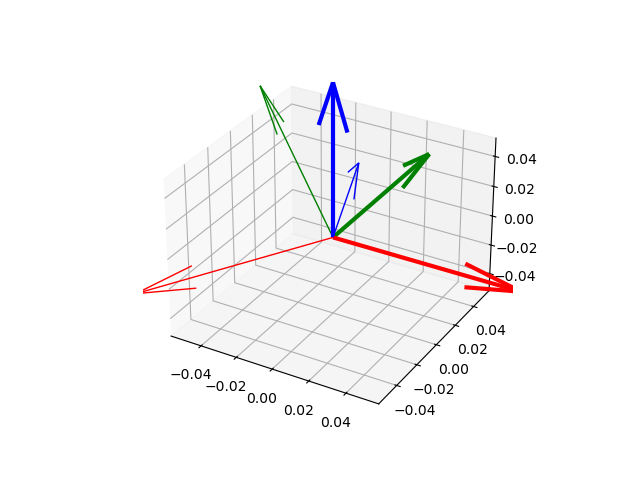

In [36]:
ax = plt.figure().add_subplot(projection='3d')

# define the axes
x1, x2, x3 = np.identity(3)

# define the main directions
x1_main, x2_main, x3_main = main_directions_true.T

# plot the axes
for (axis, color) in zip([x1, x2, x3], ['red', 'green', 'blue']):
    ax.quiver(
        0, 0, 0, axis[0], axis[1], axis[2], 
        length=0.1, linewidth=3, normalize=True, pivot='tail', color=color)

# plot the main directions
for (axis, color) in zip(main_directions_true.T, ['red', 'green', 'blue']):
    ax.quiver(
        0, 0, 0, axis[0], axis[1], axis[2], 
        length=0.1, linewidth=1, normalize=True, pivot='tail', color=color)

plt.show()